## Dependencies

In [1]:
# Import dependencies
# NFL pbp data
import nfl_data_py as nfl

# Basics / visualizations
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Machine learning tools
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Stats Stuff
from scipy import stats
from scipy.stats import skew
import statsmodels.api as sm


# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)

## Importing and Prepping Schedules

In [2]:
schedules_df = nfl.import_schedules([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

In [3]:
def calculate_implied_totals(df):
    """
    Calculate the implied home and away team totals based on the spread and total lines.
    """
    # Implied totals based on the total and spread lines
    df['implied_home_total'] = (df['total_line'] + df['spread_line']) / 2
    df['implied_away_total'] = (df['total_line'] - df['spread_line']) / 2
    
    return df

In [4]:
schedules_df = calculate_implied_totals(schedules_df)
# explore this if we can prove lines are out before upcoming week

In [5]:
schedules_df.drop(columns= ['away_coach', 'home_coach', 'referee',
       'stadium_id', 'stadium', 'away_score', 'home_score',
       'location', 'result', 'total', 'overtime', 'old_game_id', 'gsis',
       'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'away_rest', 'home_rest',
       'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds',
       'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game', 'away_qb_id', 'home_qb_id', 'gameday', 'weekday',
       'gametime'], inplace=True)

In [6]:
# Create a DataFrame for away quarterbacks
away_df = schedules_df[['game_id', 'season', 'game_type', 'week', 'away_team', 'home_team', 'away_qb_name', 'implied_away_total', 'roof', 'surface',]].copy()
away_df.rename(columns={'away_qb_name': 'qb_name', 'implied_away_total': 'implied_total'}, inplace=True)
away_df['home_away'] = 'away'
away_df['posteam'] = away_df['away_team']
away_df['defteam'] = away_df['home_team']

# Create a DataFrame for home quarterbacks
home_df = schedules_df[['game_id', 'season', 'game_type', 'week', 'away_team', 'home_team', 'home_qb_name', 'implied_home_total', 'roof', 'surface']].copy()
home_df.rename(columns={'home_qb_name': 'qb_name', 'implied_home_total': 'implied_total'}, inplace=True)
home_df['home_away'] = 'home'
home_df['posteam'] = home_df['home_team']
home_df['defteam'] = home_df['away_team']

# Concatenate both DataFrames
combined_schedule_df = pd.concat([away_df, home_df])

# Reset index for cleanliness
combined_schedule_df.reset_index(drop=True, inplace=True)

In [7]:
def format_passer_name(qb_name):
    if pd.isna(qb_name):  # Check if the name is NaN
        return ""
    
    name_parts = qb_name.split()
    
    # Extract the first name and last name
    first_name = name_parts[0]
    last_name = name_parts[-1]  # Last name should always be the last part
    
    return f"{first_name[0]}.{last_name}"

# Apply the function to create the new 'player_passer_name' column
combined_schedule_df['passer_player_name'] = combined_schedule_df['qb_name'].apply(format_passer_name)

In [8]:
#Reorder Columns
combined_schedule_df = combined_schedule_df[['game_id', 'season', 'game_type', 'week', 'roof', 'surface',
                                             'posteam', 'defteam', 'home_team', 'away_team', 'qb_name', 'passer_player_name', 'implied_total', 'home_away']]

## Importing PBP Training Data

In [9]:
# Select only the relevant columns
columns = ['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards', 
           'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
           'passing_yards', 'cpoe', 'roof', 'surface']

# Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2014,2024 + 1), columns, include_participation=False)

# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
data = data[columns]

# Drop all rows that are not a pass
data = data[data['play_type'] == 'pass']

# Drop the play type column
passer_data = data.drop(columns=['play_type'])

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


## Passer DF Prep

In [10]:
# Group the data together by passer, week, season and aggregate
passer_df = passer_data.groupby(['game_id', 'passer_player_name', 'week', 'season'], as_index=False).agg(
    {'posteam' : 'first',
     'defteam' : 'first',
     'home_team' : 'first',
     'away_team' : 'first',
     'air_yards' : 'sum',
     'yards_after_catch' : 'sum',
     'epa' : 'sum',
     'complete_pass' : 'sum',
     'incomplete_pass' : 'sum',
     'interception' : 'sum',
     'qb_hit' : 'sum',
     'sack' : 'sum',
     'pass_touchdown' : 'sum',
     'passing_yards' : 'sum',
     'cpoe' : 'mean',
     'roof' : 'first',
     'surface' : 'first'
     }
)

# Create a new column that is completion percentage
passer_df['completion_percentage'] = passer_df['complete_pass'] / (passer_df['complete_pass'] + passer_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
passer_df['pass_attempts'] = passer_df['complete_pass'] + passer_df['incomplete_pass']

# Create a new column that equals 1 if the passer is the home team and 0 if the passer is the away team
passer_df['home_flag'] = passer_df['home_team'] == passer_df['posteam']

# Reorder the columns
passer_df = passer_df[['home_team', 'away_team', 'complete_pass', 'incomplete_pass' ,'game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'passing_yards', 'home_flag', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                        'cpoe', 'roof', 'surface']]

## Defense DF Prep

In [11]:
# Select only the relevant columns
defense_columns = ['defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards',
                   'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
                   'passing_yards', 'cpoe', 'roof', 'surface']


# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
defense_data = data[defense_columns]

# Drop the play type column
defense_data = defense_data.drop(columns=['play_type'])

# Group the data together by passer, week, season and aggregate
defense_df = defense_data.groupby(['defteam', 'week', 'season'], as_index=False).agg(
    {'home_team': 'first',
     'away_team': 'first',
     'air_yards': 'sum',
     'yards_after_catch': 'sum',
     'epa': 'sum',
     'complete_pass': 'sum',
     'incomplete_pass': 'sum',
     'interception': 'sum',
     'qb_hit': 'sum',
     'sack': 'sum',
     'pass_touchdown': 'sum',
     'passing_yards': 'sum',
     'cpoe': 'mean',
     'roof': 'first',
     'surface': 'first'
     }
)

# Create a new column that is completion percentage
defense_df['completion_percentage'] = defense_df['complete_pass'] / (defense_df['complete_pass'] + defense_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
defense_df['pass_attempts'] = defense_df['complete_pass'] + defense_df['incomplete_pass']

# Create a new column that equals 1 if the defense is the home team and 0 if the defense is the away team
defense_df['home_flag'] = defense_df['home_team'] == defense_df['defteam']

# Reorder the columns
defense_df = defense_df[['home_team', 'away_team', 'complete_pass', 'incomplete_pass', 'defteam', 'season', 'week', 'home_flag', 'passing_yards', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                       'cpoe', 'roof', 'surface']]

## Preprocessing

In [12]:
def calculate_offensive_ewma(passer_df):
    """
    Calculates EWMA for offensive columns using previous weeks' data, ensuring no leakage by excluding the current week.
    Takes into account multiple seasons.
    """
    # Sort by passer, season, and week
    passer_df = passer_df.sort_values(by=['passer_player_name', 'season', 'week'])

    # Calculate the exponentially weighted moving average for each offensive feature, excluding the current week
    passer_df['completion_percentage_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['completion_percentage']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['pass_attempts_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_attempts']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['air_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['air_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['yards_after_catch_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['yards_after_catch']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['epa_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['epa']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['interception_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['interception']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['qb_hit_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['qb_hit']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['sack_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['sack']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['pass_touchdown_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_touchdown']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['passing_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['passing_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['cpoe_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['cpoe']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    return passer_df

In [13]:
def pass_cleaner(passer_df):
    """
    Preps passer df for merging; drops unnecessary columns
    """
    passer_df.drop(columns=['home_team', 'away_team', 'complete_pass', 'incomplete_pass', 'completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe', 'home_team', 'away_team', 
                                    'complete_pass', 'incomplete_pass'], inplace=True)
    
    return passer_df

In [14]:
passer_emwa = calculate_offensive_ewma(passer_df)

In [15]:
passer_prepped = pass_cleaner(passer_emwa)

In [16]:
def calculate_defensive_ewma(defense_df):
    """
    Calculates EWMA for defensive columns using previous weeks' data (excluding the current week).
    """
    # Sort by 'defteam', 'season', and 'week' in ascending order (to ensure time order)
    defense_df = defense_df.sort_values(by=['defteam', 'season', 'week'])

    # Ensure proper grouping by both defteam and season
    defense_df['completion_percentage_ewma'] = defense_df.groupby(['defteam', 'season'])['completion_percentage']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())
    
    defense_df['pass_attempts_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_attempts']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['air_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['air_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['yards_after_catch_ewma'] = defense_df.groupby(['defteam', 'season'])['yards_after_catch']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['epa_ewma'] = defense_df.groupby(['defteam', 'season'])['epa']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['interception_ewma'] = defense_df.groupby(['defteam', 'season'])['interception']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['qb_hit_ewma'] = defense_df.groupby(['defteam', 'season'])['qb_hit']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['sack_ewma'] = defense_df.groupby(['defteam', 'season'])['sack']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['pass_touchdown_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_touchdown']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['passing_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['passing_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['cpoe_ewma'] = defense_df.groupby(['defteam', 'season'])['cpoe']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    return defense_df

In [17]:
def def_cleaner(defense_df):
    """
    Preps passer df for merging; drops unnecessary columns
    """
    # Drop the non-ewma columns
    defense_df.drop(columns=['passing_yards','completion_percentage',
                            'air_yards', 'yards_after_catch', 'epa',     
                            'interception', 'qb_hit', 'sack', 'pass_touchdown', 'pass_attempts', 'cpoe', 'complete_pass', 'incomplete_pass',
                            'home_team', 'away_team'
                            ], inplace=True)
    
    return defense_df

In [18]:
defense_ewma = calculate_defensive_ewma(defense_df)

In [19]:
defense_prepped = def_cleaner(defense_ewma)

In [20]:
# Merge the defense and passer dataframes together
full_with_ewma = passer_prepped.merge(defense_prepped, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))

# Get rid of flukey rows
filtered_with_ewma = full_with_ewma[(full_with_ewma['pass_attempts'] > 8) & (full_with_ewma['passing_yards'] >= 10)]

#Ford Field is empty, you hate to see that
filtered_with_ewma['surface'].replace('', 'fieldturf', inplace=True)

C:\Users\bhugg\AppData\Local\Temp\ipykernel_25008\3866188713.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_with_ewma['surface'].replace('', 'fieldturf', inplace=True)


## Week 1 is NaN's (duh, we use past weeks for EWMA's) for MVP I'll just get rid but for future seasons/rookies I do need a strategy

In [21]:
filtered_with_ewma = filtered_with_ewma.dropna()

In [22]:
# Perform the merge based on game_id, season, week, and team
filtered_with_ewma_it = pd.merge(filtered_with_ewma, combined_schedule_df[['game_id', 'season', 'week', 'posteam', 'implied_total']], 
                     on=['game_id', 'season', 'week', 'posteam'], 
                     how='inner')

## Modeling

In [23]:
# Define the target and features
target = 'passing_yards'
features = filtered_with_ewma_it.columns.drop(['pass_attempts', 'passer_player_name', 'passing_yards', 'posteam', 'defteam', 'season', 'week', 'game_id'])

# Define categorical and numeric columns
categorical_columns = ['roof', 'surface']
numeric_columns = [col for col in features if col not in categorical_columns]

# Split the data into training (up to 2023) and testing (2024)
train_data = filtered_with_ewma_it[filtered_with_ewma_it['season'] <= 2023]
test_data = filtered_with_ewma_it[filtered_with_ewma_it['season'] == 2024]

# Separate features and target for both training and testing
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]


# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])

# Apply the transformations to the training and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert the transformed data into a LightGBM-compatible format
train_data_lgb = lgb.Dataset(X_train_transformed, label=y_train)
test_data_lgb = lgb.Dataset(X_test_transformed, label=y_test, reference=train_data_lgb)

# Set up the parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 20,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'verbose': -1,
    'bagging_freq': 1
}

# Train the model with early stopping
lgb_model = lgb.train(params, train_data_lgb, valid_sets=[test_data_lgb], callbacks=[lgb.early_stopping(stopping_rounds=10)], num_boost_round=1000)

# Make predictions on the test set
y_pred = lgb_model.predict(X_test_transformed, num_iteration=lgb_model.best_iteration)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[108]	valid_0's rmse: 72.0255
RMSE: 72.02551973698318


In [24]:
# features

In [25]:
# Ensure test_data contains the 2024 season
test_data = filtered_with_ewma_it[filtered_with_ewma_it['season'] == 2024]

In [26]:
# Add predictions to the test_data (2024) DataFrame
test_data['predicted_passing_yards'] = y_pred

# Calculate whether the model over-predicted or under-predicted
test_data['pyoe'] = test_data['passing_yards'] - test_data['predicted_passing_yards']

# # Display the updated dataframe with actual, predicted, and over/under information
# test_data[['week', 'passer_player_name', 'passing_yards', 'predicted_passing_yards', 'pyoe']].sort_values(by='predicted_passing_yards', key=abs, ascending=False).tail(60)
test_data[test_data['passer_player_name'] == 'M.Stafford']

C:\Users\bhugg\AppData\Local\Temp\ipykernel_25008\2160986620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_passing_yards'] = y_pred
C:\Users\bhugg\AppData\Local\Temp\ipykernel_25008\2160986620.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pyoe'] = test_data['passing_yards'] - test_data['predicted_passing_yards']


,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense,implied_total,predicted_passing_yards,pyoe
3947,2024_02_LA_ARI,M.Stafford,LA,ARI,2024,2,216.0,False,27.0,closed,grass,0.708333,48.000000,290.000000,171.000000,4.536420,1.000000,11.000000,2.000000,1.000000,317.000000,0.365350,True,0.782609,23.000000,166.000000,125.000000,9.161098,0.000000,3.000000,2.000000,2.000000,232.000000,9.891942,24.25,252.160889,-36.160889
3948,2024_03_SF_LA,M.Stafford,LA,SF,2024,3,221.0,True,25.0,dome,matrixturf,0.704861,32.250000,191.750000,120.750000,-7.235589,0.250000,9.500000,4.250000,0.250000,241.250000,1.146400,False,0.700893,25.000000,176.250000,143.250000,-5.164260,1.000000,5.500000,3.250000,2.000000,251.750000,0.012892,19.25,231.378272,-10.378272
3949,2024_04_LA_CHI,M.Stafford,LA,CHI,2024,4,224.0,False,28.0,outdoors,grass,0.659957,27.230769,241.076923,93.923077,0.133133,0.076923,6.384615,3.384615,0.769231,227.230769,2.933708,True,0.580769,23.076923,214.846154,102.153846,-8.152449,1.538462,3.769231,1.615385,0.307692,185.384615,-7.175210,18.50,219.073748,4.926252
3950,2024_05_GB_LA,M.Stafford,LA,GB,2024,5,260.0,True,44.0,dome,matrixturf,0.696629,27.750000,214.025000,89.250000,-1.500879,0.700000,6.125000,3.125000,0.250000,225.050000,0.947406,False,0.741442,28.450000,284.125000,117.800000,1.330000,1.400000,4.625000,3.275000,2.600000,266.375000,8.075568,23.25,232.745262,27.254738


## Current Week Preprocessing

In [27]:
passer_df[(passer_df['passer_player_name'] == 'M.Stafford') & (passer_df['season'] == 2024)]

,home_team,away_team,complete_pass,incomplete_pass,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag,completion_percentage,pass_attempts,air_yards,yards_after_catch,epa,interception,qb_hit,sack,pass_touchdown,cpoe,roof,surface
6659,DET,LA,34.0,14.0,2024_01_LA_DET,M.Stafford,LA,DET,2024,1,317.0,False,0.708333,48.0,290.0,171.0,4.536420,1.0,11.0,2.0,1.0,0.365350,dome,fieldturf
6692,ARI,LA,19.0,8.0,2024_02_LA_ARI,M.Stafford,LA,ARI,2024,2,216.0,False,0.703704,27.0,159.0,104.0,-11.159593,0.0,9.0,5.0,0.0,1.406750,closed,grass
6750,LA,SF,16.0,9.0,2024_03_SF_LA,M.Stafford,LA,SF,2024,3,221.0,True,0.640000,25.0,263.0,82.0,3.408121,0.0,5.0,3.0,1.0,3.728067,dome,matrixturf
6772,CHI,LA,20.0,8.0,2024_04_LA_CHI,M.Stafford,LA,CHI,2024,4,224.0,False,0.714286,28.0,201.0,87.0,-2.287626,1.0,6.0,3.0,0.0,-0.008961,outdoors,grass
6809,LA,GB,29.0,15.0,2024_05_GB_LA,M.Stafford,LA,GB,2024,5,260.0,True,0.659091,44.0,367.0,117.0,-8.967316,1.0,9.0,3.0,1.0,-5.189738,dome,matrixturf


In [28]:
def calculate_ewma_tester_off(passer_df):
    """
    Calculates EWMA for offensive columns using the current and previous weeks' data, including the current week.
    Takes into account multiple seasons.
    """
    # Sort by passer, season, and week
    passer_df = passer_df.sort_values(by=['passer_player_name', 'season', 'week'])

    # Calculate the exponentially weighted moving average for each offensive feature, including the current week
    passer_df['completion_percentage_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['completion_percentage']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['pass_attempts_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_attempts']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['air_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['air_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['yards_after_catch_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['yards_after_catch']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['epa_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['epa']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['interception_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['interception']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['qb_hit_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['qb_hit']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['sack_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['sack']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['pass_touchdown_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_touchdown']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['passing_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['passing_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['cpoe_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['cpoe']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    return passer_df

In [29]:
passer_df_tester = passer_df[(passer_df['season'] == 2024)]

In [30]:
prediction_set_passer_nc = calculate_ewma_tester_off(passer_df_tester)

In [31]:
prediction_set_passer = pass_cleaner(prediction_set_passer_nc)

In [32]:
def calculate_ewma_tester_def(defense_df):
    """
    Calculates EWMA for defensive columns using previous weeks' data (excluding the current week).
    """
    # Sort by 'defteam', 'season', and 'week' in ascending order (to ensure time order)
    defense_df = defense_df.sort_values(by=['defteam', 'season', 'week'])

    # Ensure proper grouping by both defteam and season
    defense_df['completion_percentage_ewma'] = defense_df.groupby(['defteam', 'season'])['completion_percentage']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())
    
    defense_df['pass_attempts_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_attempts']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['air_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['air_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['yards_after_catch_ewma'] = defense_df.groupby(['defteam', 'season'])['yards_after_catch']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['epa_ewma'] = defense_df.groupby(['defteam', 'season'])['epa']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['interception_ewma'] = defense_df.groupby(['defteam', 'season'])['interception']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['qb_hit_ewma'] = defense_df.groupby(['defteam', 'season'])['qb_hit']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['sack_ewma'] = defense_df.groupby(['defteam', 'season'])['sack']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['pass_touchdown_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_touchdown']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['passing_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['passing_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['cpoe_ewma'] = defense_df.groupby(['defteam', 'season'])['cpoe']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    return defense_df

In [33]:
defense_df_tester = defense_df[defense_df['season'] == 2024]

In [34]:
prediction_set_defense_nc = calculate_ewma_tester_def(defense_df_tester)

In [35]:
prediction_set_defense = def_cleaner(prediction_set_defense_nc)

In [133]:
prediction_set_defense

,defteam,season,week,home_flag,roof,surface,completion_percentage_ewma,pass_attempts_ewma,air_yards_ewma,yards_after_catch_ewma,epa_ewma,interception_ewma,qb_hit_ewma,sack_ewma,pass_touchdown_ewma,passing_yards_ewma,cpoe_ewma
10,ARI,2024,1,False,outdoors,a_turf,0.782609,23.000000,166.000000,125.000000,9.161098,0.000000,3.000000,2.000000,2.000000,232.000000,9.891942
21,ARI,2024,2,True,closed,grass,0.723430,26.000000,160.750000,109.250000,-6.079420,0.000000,7.500000,4.250000,0.500000,220.000000,3.528048
32,ARI,2024,3,True,closed,grass,0.789027,23.230769,173.384615,89.692308,2.192668,0.692308,3.692308,2.692308,1.538462,205.461538,8.496043
42,ARI,2024,4,True,closed,grass,0.861606,27.125000,173.800000,111.500000,10.271467,0.900000,1.875000,0.875000,1.175000,224.050000,12.432129
53,ARI,2024,5,False,outdoors,grass,0.670253,31.057851,258.950413,105.809917,2.795163,1.636364,3.966942,1.628099,1.057851,237.404959,2.237395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,WAS,2024,2,True,outdoors,grass,0.628571,28.500000,251.000000,121.000000,10.266665,0.000000,4.000000,1.000000,2.500000,205.750000,0.815500
5495,WAS,2024,3,False,outdoors,fieldturf,0.721747,35.076923,273.153846,120.307692,14.255255,0.000000,4.000000,1.692308,2.846154,287.615385,6.614070
5505,WAS,2024,4,False,closed,grass,0.725477,26.250000,182.600000,81.625000,0.559953,0.000000,4.675000,3.250000,1.600000,189.325000,2.428467
5515,WAS,2024,5,True,outdoors,grass,0.609163,28.090909,229.727273,87.231405,-9.364010,0.000000,8.239669,5.760331,1.198347,156.975207,-4.550344


In [119]:
# Merge the defense and passer dataframes together
prediction_set = prediction_set_passer.merge(prediction_set_defense, how='inner', on=['season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))

# Get rid of flukey rows
filtered_prediction_set = prediction_set[(prediction_set['pass_attempts'] > 8) & (prediction_set['passing_yards'] >= 10)]

#Ford Field is empty, you hate to see that
filtered_prediction_set['surface'].replace('', 'fieldturf', inplace=True)

C:\Users\bhugg\AppData\Local\Temp\ipykernel_25008\569776864.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_prediction_set['surface'].replace('', 'fieldturf', inplace=True)


In [120]:
filtered_prediction_set.drop(columns = ['game_id', 'passing_yards', 'pass_attempts'], inplace=True)

C:\Users\bhugg\AppData\Local\Temp\ipykernel_25008\3499550841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_prediction_set.drop(columns = ['game_id', 'passing_yards', 'pass_attempts'], inplace=True)


In [121]:
# Group by 'posteam' and get the row corresponding to the most recent week (max week)
filtered_prediction_set_recents = filtered_prediction_set.loc[filtered_prediction_set.groupby('posteam')['week'].idxmax()]

In [126]:
def update_week_to_next(df):
    """
    Function to update all teams to the next NFL week based on the current max week.
    Teams that are behind the max week will jump to the next NFL week.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing NFL data including the 'week' column.
    
    Returns:
    pd.DataFrame: DataFrame with 'week' values updated appropriately.
    """
    # Copy the dataframe to avoid altering the original
    df_copy = df.copy()

    # Find the maximum value of 'week' in the dataframe (the current NFL week)
    current_week = df_copy['week'].max()

    # Increment all weeks to the next NFL week (based on current max week)
    df_copy['week'] = df_copy['week'].apply(lambda x: current_week + 1)
    
    return df_copy

In [127]:
current_week_pred_set = update_week_to_next(filtered_prediction_set_recents)

In [130]:
current_week_pred_set.drop(columns=['defteam_passer', ''])

(32, 32)

In [132]:
current_week_pred_set

,passer_player_name,posteam,defteam_passer,season,week,home_flag_passer,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,defteam_defense,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
790,K.Murray,ARI,GB,2024,7,False,outdoors,grass,0.682970,30.521978,200.189560,93.653846,-1.981662,0.247253,1.604396,0.563187,1.016484,204.543956,-1.080490,ARI,False,0.696572,31.019231,215.590659,127.299451,10.845869,1.211538,2.653846,0.541209,3.021978,251.153846,3.524045
776,K.Cousins,ATL,CAR,2024,7,False,outdoors,grass,0.663803,35.782967,247.126374,135.365385,9.607460,0.326923,4.807692,1.027473,1.601648,289.225275,1.754773,ARI,False,0.696572,31.019231,215.590659,127.299451,10.845869,1.211538,2.653846,0.541209,3.021978,251.153846,3.524045
804,L.Jackson,BAL,WAS,2024,7,True,outdoors,grass,0.752498,28.109890,269.332418,148.239011,13.018944,0.675824,4.420330,1.651099,1.741758,311.925824,11.262043,ARI,False,0.696572,31.019231,215.590659,127.299451,10.845869,1.211538,2.653846,0.541209,3.021978,251.153846,3.524045
1570,J.Allen,BUF,NYJ,2024,7,False,outdoors,fieldturf,0.641791,26.478022,247.519231,89.173077,6.209240,0.000000,3.964286,1.785714,1.670330,194.318681,7.078369,BUF,False,0.696525,33.835165,244.859890,142.568681,8.625956,0.939560,5.197802,2.450549,1.741758,288.815934,1.799524
650,A.Dalton,CAR,ATL,2024,7,True,outdoors,grass,0.697333,33.950413,247.983471,73.611570,-6.971384,1.636364,3.818182,0.719008,1.561983,202.561983,0.772449,ARI,False,0.696572,31.019231,215.590659,127.299451,10.845869,1.211538,2.653846,0.541209,3.021978,251.153846,3.524045
678,C.Williams,CHI,JAX,2024,7,True,outdoors,grass,0.780058,28.431319,150.002747,144.964286,12.438343,0.733516,3.554945,2.609890,3.239011,240.832418,12.162312,ARI,False,0.696572,31.019231,215.590659,127.299451,10.845869,1.211538,2.653846,0.541209,3.021978,251.153846,3.524045
1758,J.Burrow,CIN,NYG,2024,7,False,outdoors,fieldturf,0.709202,30.689560,197.851648,119.945055,5.977585,0.296703,6.980769,3.420330,1.351648,253.884615,10.554017,CIN,False,0.601352,38.505495,300.332418,133.293956,-3.942960,0.758242,5.837912,1.626374,1.104396,238.469780,-5.211413
692,D.Watson,CLE,PHI,2024,7,False,outdoors,grass,0.661942,25.197802,166.307692,111.032967,-3.391465,0.079670,8.766484,5.348901,0.348901,159.868132,-2.221175,ARI,False,0.696572,31.019231,215.590659,127.299451,10.845869,1.211538,2.653846,0.541209,3.021978,251.153846,3.524045
1770,C.Rush,DAL,DET,2024,7,True,closed,matrixturf,0.683333,8.250000,32.250000,20.000000,-6.725464,0.750000,0.000000,0.000000,0.000000,36.000000,-8.447230,DAL,True,0.679453,27.760989,280.167582,151.978022,11.024082,0.087912,5.642857,2.769231,2.491758,284.162088,4.749412
664,B.Nix,DEN,LAC,2024,7,True,outdoors,grass,0.618549,30.274725,280.648352,82.291209,-3.002770,0.689560,4.505495,2.024725,1.854396,202.236264,-4.485404,ARI,False,0.696572,31.019231,215.590659,127.299451,10.845869,1.211538,2.653846,0.541209,3.021978,251.153846,3.524045


In [131]:
defense_columns = [
    'season', 'week', 'defteam', 'completion_percentage_ewma_defense', 'pass_attempts_ewma_defense',
    'air_yards_ewma_defense', 'yards_after_catch_ewma_defense', 'epa_ewma_defense',
    'interception_ewma_defense', 'qb_hit_ewma_defense', 'sack_ewma_defense',
    'pass_touchdown_ewma_defense', 'passing_yards_ewma_defense', 'cpoe_ewma_defense'
]

defense_df_tbj = current_week_pred_set[defense_columns]

KeyError: "['defteam'] not in index"

In [115]:
defense_df_tbj['defteam'].nunique()

28

In [74]:
offense_columns = [
    'season', 'week', 'posteam', 'passer_player_name',
    'completion_percentage_ewma_passer', 'pass_attempts_ewma_passer', 'air_yards_ewma_passer',
    'yards_after_catch_ewma_passer', 'epa_ewma_passer', 'interception_ewma_passer',
    'qb_hit_ewma_passer', 'sack_ewma_passer', 'pass_touchdown_ewma_passer',
    'passing_yards_ewma_passer', 'cpoe_ewma_passer'
]

offense_df_tbj = current_week_pred_set[offense_columns]

In [107]:
offense_df_tbj.shape

(32, 15)

In [75]:
combined_schedule_preds = combined_schedule_df[combined_schedule_df['season'] == combined_schedule_df['season'].max()]
# combined_schedule_preds[combined_schedule_preds['week'] == 6]
combined_schedule_preds = combined_schedule_preds.sort_values(by=['week'])

## fucking bye weeks are selling me

In [77]:
# Merge the two DataFrames on relevant columns, avoiding duplicates
off_plus_schedule = pd.merge(
    offense_df_tbj, 
    combined_schedule_preds, 
    on=['season', 'week', 'posteam'], 
    suffixes=('', '_implied'), 
    how='inner'
)

#good up to here

In [110]:
off_plus_schedule

,season,week,posteam,passer_player_name,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,game_id,game_type,roof,surface,defteam,home_team,away_team,qb_name,passer_player_name_implied,implied_total,home_away
0,2024,7,ARI,K.Murray,0.682970,30.521978,200.189560,93.653846,-1.981662,0.247253,1.604396,0.563187,1.016484,204.543956,-1.080490,2024_07_LAC_ARI,REG,closed,grass,LAC,ARI,LAC,Kyler Murray,K.Murray,20.75,home
1,2024,7,ATL,K.Cousins,0.663803,35.782967,247.126374,135.365385,9.607460,0.326923,4.807692,1.027473,1.601648,289.225275,1.754773,2024_07_SEA_ATL,REG,closed,fieldturf,SEA,ATL,SEA,Kirk Cousins,K.Cousins,27.00,home
2,2024,7,BAL,L.Jackson,0.752498,28.109890,269.332418,148.239011,13.018944,0.675824,4.420330,1.651099,1.741758,311.925824,11.262043,2024_07_BAL_TB,REG,outdoors,grass,TB,TB,BAL,Lamar Jackson,L.Jackson,26.00,away
3,2024,7,BUF,J.Allen,0.641791,26.478022,247.519231,89.173077,6.209240,0.000000,3.964286,1.785714,1.670330,194.318681,7.078369,2024_07_TEN_BUF,REG,outdoors,a_turf,TEN,BUF,TEN,Josh Allen,J.Allen,25.00,home
4,2024,7,CAR,A.Dalton,0.697333,33.950413,247.983471,73.611570,-6.971384,1.636364,3.818182,0.719008,1.561983,202.561983,0.772449,2024_07_CAR_WAS,REG,outdoors,grass,WAS,WAS,CAR,Andy Dalton,A.Dalton,22.00,away
5,2024,7,CIN,J.Burrow,0.709202,30.689560,197.851648,119.945055,5.977585,0.296703,6.980769,3.420330,1.351648,253.884615,10.554017,2024_07_CIN_CLE,REG,outdoors,grass,CLE,CLE,CIN,Joe Burrow,J.Burrow,24.25,away
6,2024,7,CLE,D.Watson,0.661942,25.197802,166.307692,111.032967,-3.391465,0.079670,8.766484,5.348901,0.348901,159.868132,-2.221175,2024_07_CIN_CLE,REG,outdoors,grass,CIN,CLE,CIN,Deshaun Watson,D.Watson,17.75,home
7,2024,7,DEN,B.Nix,0.618549,30.274725,280.648352,82.291209,-3.002770,0.689560,4.505495,2.024725,1.854396,202.236264,-4.485404,2024_07_DEN_NO,REG,dome,sportturf,NO,NO,DEN,Bo Nix,B.Nix,19.50,away
8,2024,7,DET,J.Goff,0.787701,23.900826,211.818182,171.132231,17.145394,0.132231,4.677686,2.173554,2.611570,300.231405,12.160240,2024_07_DET_MIN,REG,dome,sportturf,MIN,MIN,DET,Jared Goff,J.Goff,23.75,away
9,2024,7,GB,J.Love,0.673970,31.200000,228.825000,135.900000,9.252202,1.150000,2.875000,0.550000,3.500000,260.225000,-0.340950,2024_07_HOU_GB,REG,outdoors,grass,HOU,GB,HOU,Jordan Love,J.Love,25.25,home


In [112]:
defense_df_tbj.sort_values(by='defteam')

,season,week,defteam,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
163,2024,7,ARI,0.696572,31.019231,215.590659,127.299451,10.845869,1.211538,2.653846,0.541209,3.021978,251.153846,3.524045
7,2024,7,ATL,0.743136,33.211538,221.115385,86.711538,-1.123934,1.442308,2.673077,0.310440,2.060440,212.620879,3.482650
133,2024,7,BAL,0.696420,35.760989,295.285714,114.697802,11.017868,0.233516,7.532967,3.013736,2.508242,292.755495,8.694164
26,2024,7,BUF,0.696525,33.835165,244.859890,142.568681,8.625956,0.939560,5.197802,2.450549,1.741758,288.815934,1.799524
168,2024,7,CAR,0.656030,29.892857,190.016484,124.145604,8.526491,0.107143,2.763736,0.307692,1.335165,244.002747,1.503620
183,2024,7,CHI,0.675484,33.832418,287.167582,107.346154,-4.227375,1.019231,7.032967,3.840659,1.346154,226.626374,4.243830
81,2024,7,CIN,0.601352,38.505495,300.332418,133.293956,-3.942960,0.758242,5.837912,1.626374,1.104396,238.469780,-5.211413
156,2024,7,CLE,0.616713,25.670330,259.109890,120.637363,4.435480,0.222527,2.590659,1.574176,1.609890,246.541209,-1.236159
108,2024,7,DAL,0.679453,27.760989,280.167582,151.978022,11.024082,0.087912,5.642857,2.769231,2.491758,284.162088,4.749412
151,2024,7,DEN,0.625439,34.401099,286.365385,120.579670,0.246667,0.695055,6.596154,3.236264,0.925824,231.774725,-0.115180


In [104]:
# Check for teams or weeks that exist in one dataframe but not the other
missing_defteam = set(off_plus_schedule['defteam']).difference(defense_df_tbj['defteam'])
missing_week = set(off_plus_schedule['week']).difference(defense_df_tbj['week'])
print("Missing defteam in defense_df_tbj:", missing_defteam)
print("Missing weeks in defense_df_tbj:", missing_week)

Missing defteam in defense_df_tbj: {'LA', 'MIA', 'MIN', 'KC'}
Missing weeks in defense_df_tbj: set()


In [83]:
# Perform the merge on season, week, and defteam
full_pred_features = pd.merge(
    off_plus_schedule,
    defense_df_tbj,
    on=['season', 'week', 'defteam'],  # Merging on these columns
    suffixes=('_offense', '_defense'),
    how='inner'  # Use inner join to avoid boof rows
)

#WOAHHHHH RICKY

In [51]:
# List of the new column order
new_column_order = ['game_id', 'season', 'week','game_type','posteam', 'defteam', 'home_team', 'away_team', 'qb_name', 'passer_player_name',
                    'home_away', 'implied_total', 'roof', 'surface',
       'completion_percentage_ewma_passer', 'pass_attempts_ewma_passer',
       'air_yards_ewma_passer', 'yards_after_catch_ewma_passer',
       'epa_ewma_passer', 'interception_ewma_passer', 'qb_hit_ewma_passer',
       'sack_ewma_passer', 'pass_touchdown_ewma_passer',
       'passing_yards_ewma_passer', 'cpoe_ewma_passer', 'completion_percentage_ewma_defense',
       'pass_attempts_ewma_defense', 'air_yards_ewma_defense',
       'yards_after_catch_ewma_defense', 'epa_ewma_defense',
       'interception_ewma_defense', 'qb_hit_ewma_defense', 'sack_ewma_defense',
       'pass_touchdown_ewma_defense', 'passing_yards_ewma_defense',
       'cpoe_ewma_defense']

# Reorder inplace
full_pred_features = full_pred_features[new_column_order]

# Create the home_flag_passer column
full_pred_features['home_flag_passer'] = full_pred_features['posteam'] == full_pred_features['home_team']

# Create the home_flag_defense column
full_pred_features['home_flag_defense'] = full_pred_features['defteam'] == full_pred_features['home_team']

In [59]:
full_pred_features[full_pred_features['posteam'] == 'DET']

,game_id,season,week,game_type,posteam,defteam,home_team,away_team,qb_name,passer_player_name,home_away,implied_total,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense,home_flag_passer,home_flag_defense
109,2024_03_DET_ARI,2024,3,REG,DET,ARI,ARI,DET,Jared Goff,J.Goff,away,27.25,closed,grass,0.657051,45.750000,321.250000,141.250000,-11.440338,1.750000,8.750000,0.500000,0.250000,284.500000,-4.864757,0.723430,26.000000,160.750000,109.250000,-6.079420,0.000000,7.500000,4.25,0.500000,220.000000,3.528048,False,True
110,2024_02_TB_DET,2024,2,REG,DET,TB,DET,TB,Jared Goff,J.Goff,home,29.50,dome,fieldturf,0.666667,27.000000,187.000000,148.000000,-4.808456,1.000000,5.000000,2.000000,1.000000,217.000000,-7.549820,0.708333,24.000000,125.000000,154.000000,-1.738880,0.000000,2.000000,2.00,0.000000,184.000000,-3.183150,True,False
111,2024_04_SEA_DET,2024,4,REG,DET,SEA,DET,SEA,Jared Goff,J.Goff,home,25.00,dome,fieldturf,0.768603,29.307692,222.769231,99.538462,0.543155,1.230769,4.076923,1.538462,1.461538,225.307692,5.913641,0.610897,31.461538,196.384615,89.692308,-13.636182,0.153846,10.538462,5.00,0.230769,173.769231,-1.452892,True,False
112,2024_04_SEA_DET,2024,4,REG,DET,SEA,DET,SEA,Jared Goff,J.Goff,home,25.00,dome,fieldturf,0.768603,29.307692,222.769231,99.538462,0.543155,1.230769,4.076923,1.538462,1.461538,225.307692,5.913641,0.610897,31.461538,196.384615,89.692308,-13.636182,0.153846,10.538462,5.00,0.230769,173.769231,-1.452892,True,False


In [94]:
selected_columns = ['game_id', 'season', 'week','game_type','posteam', 'defteam', 'home_team', 'away_team', 'qb_name', 'passer_player_name',
                    'home_away', 'implied_total']
predictions_clean = full_pred_features[selected_columns]

In [89]:
# Function to make predictions on a new dataframe
def make_predictions(new_data, model, preprocessor, features, categorical_columns, numeric_columns):
    # Ensure the new data has the required columns
    new_data = new_data[features]

    # Apply the same preprocessing (OneHotEncoding and Scaling)
    new_data_transformed = preprocessor.transform(new_data)
    
    # Use the trained model to make predictions
    predictions = model.predict(new_data_transformed, num_iteration=model.best_iteration)
    
    return predictions

In [95]:
# Call the function to make predictions
predictions = make_predictions(full_pred_features, lgb_model, preprocessor, features, categorical_columns, numeric_columns)

predictions_clean['predicted_passing_yards'] = predictions

C:\Users\bhugg\AppData\Local\Temp\ipykernel_24424\3304664529.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_clean['predicted_passing_yards'] = predictions


In [120]:
predictions_clean[predictions_clean['posteam'] == 'DET'].sort_values(by='week')

,game_id,season,week,game_type,posteam,defteam,home_team,away_team,qb_name,passer_player_name,home_away,implied_total,predicted_passing_yards
99,2024_02_TB_DET,2024,2,REG,DET,TB,DET,TB,Jared Goff,J.Goff,home,29.50,245.880649
98,2024_03_DET_ARI,2024,3,REG,DET,ARI,ARI,DET,Jared Goff,J.Goff,away,27.25,255.301176
100,2024_04_SEA_DET,2024,4,REG,DET,SEA,DET,SEA,Jared Goff,J.Goff,home,25.00,247.543246
101,2024_04_SEA_DET,2024,4,REG,DET,SEA,DET,SEA,Jared Goff,J.Goff,home,25.00,247.543246


## Charts for model stuff if I need to look. It's a pretty shit model. It does ok I guess but not a lot of variance in projection lmao

In [710]:
# # Plotting the histogram of PYOE
# plt.figure(figsize=(10, 6))
# plt.hist(test_data['pyoe'], bins=25, edgecolor='black', alpha=0.7)
# plt.title('Distribution of Pass Yards Over Expected (PYOE)', fontsize=16)
# plt.xlabel('PYOE (Predicted Passing Yards - Actual Passing Yards)', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)
# plt.grid(True, alpha=0.5)

# # Show the plot
# plt.show()

In [709]:
# # Plotting the histogram of PYOE
# plt.figure(figsize=(10, 6))
# plt.hist(test_data['passing_yards'], bins=30, edgecolor='black', alpha=0.7)
# plt.title('Distribution of Pass Yards', fontsize=16)
# plt.xlabel('Passing Yards', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)
# plt.grid(True, alpha=0.5)

# # Show the plot
# plt.show()

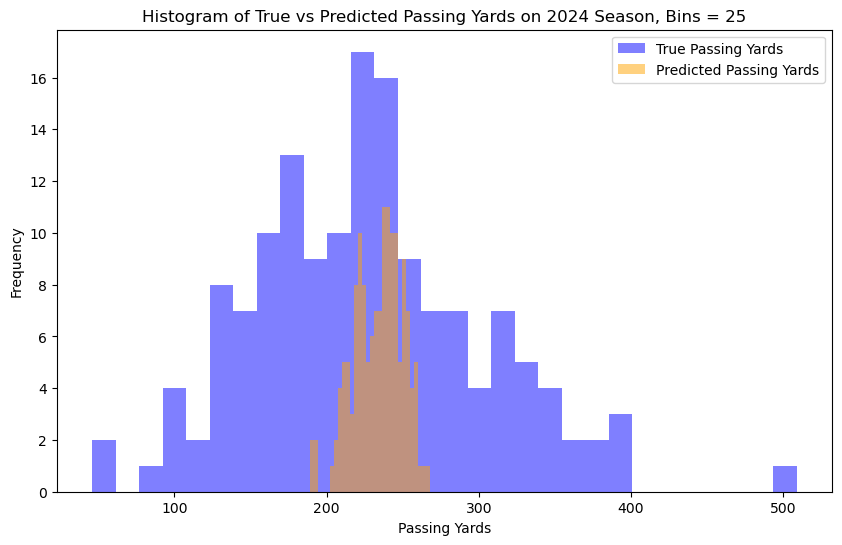

In [93]:
# Plotting the histogram of predicted passing yards and true passing yards
plt.figure(figsize=(10, 6))

# Plot histogram for true passing yards
plt.hist(test_data['passing_yards'], bins=30, alpha=0.5, label='True Passing Yards', color='blue')

# Plot histogram for predicted passing yards
plt.hist(test_data['predicted_passing_yards'], bins=30, alpha=0.5, label='Predicted Passing Yards', color='orange')

# Adding labels and title
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of True vs Predicted Passing Yards on 2024 Season, Bins = 25')
plt.legend(loc='upper right')

# Show the plot
plt.show()